In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd

In [0]:
import os
PATH_TO_DATA = '/content/gdrive/My Drive/mlcourse/dota/'

In [0]:
df_train_features = pd.read_csv(PATH_TO_DATA + 'train_features_new.csv', index_col = 'match_id_hash')

In [0]:
df_train_targets = pd.read_csv(PATH_TO_DATA + 'df_train_targets.csv', index_col='match_id_hash')

In [0]:
y = df_train_targets['radiant_win'].values

In [0]:
import lightgbm
from sklearn.model_selection import train_test_split

In [0]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

In [0]:
from sklearn.model_selection import StratifiedKFold
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [0]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lightgbm.Dataset(X_train, label=y_train)
            valid_data = lightgbm.Dataset(X_valid, label=y_valid)
            
            model = lightgbm.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [0]:
heroes_col = ['r1_hero_id',
              'r2_hero_id',
              'r3_hero_id',
              'r4_hero_id',
              'r5_hero_id',
              'd1_hero_id',
              'd2_hero_id',
              'd3_hero_id',
              'd4_hero_id',
              'd5_hero_id',
              ]

In [0]:
df_train_heroes = df_train_features[heroes_col]
df_train_heroes_r1 = pd.get_dummies(df_train_heroes['r1_hero_id'], prefix = 'r')
df_train_heroes_r2 = pd.get_dummies(df_train_heroes['r2_hero_id'], prefix = 'r')
df_train_heroes_r3 = pd.get_dummies(df_train_heroes['r3_hero_id'], prefix = 'r')
df_train_heroes_r4 = pd.get_dummies(df_train_heroes['r4_hero_id'], prefix = 'r')
df_train_heroes_r5 = pd.get_dummies(df_train_heroes['r5_hero_id'], prefix = 'r')

df_train_heroes_r = df_train_heroes_r1 | df_train_heroes_r2 | df_train_heroes_r3 | df_train_heroes_r4 | df_train_heroes_r5

df_train_heroes_d1 = pd.get_dummies(df_train_heroes['d1_hero_id'], prefix = 'd')
df_train_heroes_d2 = pd.get_dummies(df_train_heroes['d2_hero_id'], prefix = 'd')
df_train_heroes_d3 = pd.get_dummies(df_train_heroes['d3_hero_id'], prefix = 'd')
df_train_heroes_d4 = pd.get_dummies(df_train_heroes['d4_hero_id'], prefix = 'd')
df_train_heroes_d5 = pd.get_dummies(df_train_heroes['d5_hero_id'], prefix = 'd')

df_train_heroes_d = df_train_heroes_d1 | df_train_heroes_d2 | df_train_heroes_d3 | df_train_heroes_d4 | df_train_heroes_d5

df_train_heroes_ohe = pd.concat([df_train_heroes_r, df_train_heroes_d], axis = 1)

In [0]:
df_test_features = pd.read_csv(PATH_TO_DATA + 'test_features_new.csv', index_col = 'match_id_hash')
df_test_heroes = df_test_features[heroes_col]

df_test_heroes_r1 = pd.get_dummies(df_test_heroes['r1_hero_id'], prefix = 'r')
df_test_heroes_r2 = pd.get_dummies(df_test_heroes['r2_hero_id'], prefix = 'r')
df_test_heroes_r3 = pd.get_dummies(df_test_heroes['r3_hero_id'], prefix = 'r')
df_test_heroes_r4 = pd.get_dummies(df_test_heroes['r4_hero_id'], prefix = 'r')
df_test_heroes_r5 = pd.get_dummies(df_test_heroes['r5_hero_id'], prefix = 'r')

df_test_heroes_r = df_test_heroes_r1 | df_test_heroes_r2 | df_test_heroes_r3 | df_test_heroes_r4 | df_test_heroes_r5

df_test_heroes_d1 = pd.get_dummies(df_test_heroes['d1_hero_id'], prefix = 'd')
df_test_heroes_d2 = pd.get_dummies(df_test_heroes['d2_hero_id'], prefix = 'd')
df_test_heroes_d3 = pd.get_dummies(df_test_heroes['d3_hero_id'], prefix = 'd')
df_test_heroes_d4 = pd.get_dummies(df_test_heroes['d4_hero_id'], prefix = 'd')
df_test_heroes_d5 = pd.get_dummies(df_test_heroes['d5_hero_id'], prefix = 'd')

df_test_heroes_d = df_test_heroes_d1 | df_test_heroes_d2 | df_test_heroes_d3 | df_test_heroes_d4 | df_test_heroes_d5

df_test_heroes_ohe = pd.concat([df_test_heroes_r, df_test_heroes_d], axis = 1)

In [0]:
df_test_features = pd.read_csv(PATH_TO_DATA + 'test_features_new.csv', index_col = 'match_id_hash')

In [0]:
new_col = list(df_train_features.columns[305:]) + list(df_train_features.columns[:5])

In [0]:
def prepare_data(df_train_features):
    df_train_features.fillna(-1,inplace=True)
    N=120
    X_pick = np.zeros((df_train_features.shape[0], N))

    for i, match_id in enumerate(df_train_features.index):
        for p in range(5):
            X_pick[i, df_train_features.ix[match_id, 'r%d_hero_id' % (p+1)]-1] = 1
            X_pick[i, df_train_features.ix[match_id, 'd%d_hero_id' % (p+1)]-1] = -1
    columns = ['hero_{}'.format(x) for x in range(1,121)]
    bag_of_heroes = pd.DataFrame(data=X_pick, index=df_train_features.index, columns=columns)
    df_train_features = df_train_features.join(bag_of_heroes.astype(int))
    df_train_features.drop([ 
                             'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
                             'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'
                            ],axis=1,inplace=True)
    all_hero_features = ['_kills', '_deaths', '_assists', '_denies', '_gold', '_lh','_xp', '_health', '_max_health', '_max_mana', '_level', '_x',
     '_y','_stuns', '_creeps_stacked', '_camps_stacked', '_rune_pickups', '_firstblood_claimed', '_teamfight_participation', 
     '_towers_killed', '_roshans_killed', '_obs_placed', '_sen_placed']
    hero_lin_features = ['_level', '_xp', '_gold', '_lh', '_kills', '_deaths', '_creeps_stacked']

    for feature in all_hero_features:
        df_train_features['radiant{}'.format(feature)] = 0
        df_train_features['dire{}'.format(feature)] = 0
        for i in range(1,6):
            df_train_features['radiant{}'.format(feature)] += df_train_features['r{0}{1}'.format(i,feature)]
            df_train_features['dire{}'.format(feature)] += df_train_features['d{0}{1}'.format(i,feature)]

    for i in range(1,6):
        df_train_features['rad_hero{}_coolnes'.format(i)] =  0.25 * df_train_features['r{}_level'.format(i)] + \
                                                             0.15 * df_train_features['r{}_xp'.format(i)] + \
                                                             0.1  * df_train_features['r{}_gold'.format(i)] + \
                                                             0.1  * df_train_features['r{}_lh'.format(i)] + \
                                                             0.3  * df_train_features['r{}_kills'.format(i)] - \
                                                             0.3  * df_train_features['r{}_deaths'.format(i)] + \
                                                             0.3  * df_train_features['r{}_creeps_stacked'.format(i)]
        df_train_features['dire_hero{}_coolnes'.format(i)] = 0.25 * df_train_features['d{}_level'.format(i)] + \
                                                             0.15 * df_train_features['d{}_xp'.format(i)] + \
                                                             0.1  * df_train_features['d{}_gold'.format(i)] + \
                                                             0.1  * df_train_features['d{}_lh'.format(i)] + \
                                                             0.3  * df_train_features['d{}_kills'.format(i)] - \
                                                             0.3  * df_train_features['d{}_deaths'.format(i)] + \
                                                             0.3  * df_train_features['d{}_creeps_stacked'.format(i)]
    for feature in all_hero_features:
        df_train_features['diff_{}'.format(feature)] = df_train_features['radiant{}'.format(feature)] - df_train_features['dire{}'.format(feature)]
        df_train_features['relation_{}'.format(feature)] = df_train_features['radiant{}'.format(feature)] / (df_train_features['dire{}'.format(feature)] + 0.000001)
        df_train_features['MSE_{}'.format(feature)] = df_train_features['diff_{}'.format(feature)] / (df_train_features['dire{}'.format(feature)] + df_train_features['radiant{}'.format(feature)] + 0.000001)
    return(df_train_features)

In [0]:
df_train_features_extd = df_train_features.copy()
df_test_features_extd  = df_test_features.copy()

df_train_features_extd = prepare_data(df_train_features_extd)
df_test_features_extd  = prepare_data(df_test_features_extd)

df_train = pd.concat([df_train_features_extd.copy()[new_col], df_train_heroes_ohe], axis = 1)
df_test  = pd.concat([df_test_features_extd.copy()[new_col],  df_test_heroes_ohe], axis = 1)

X_test = df_test.copy().reset_index(drop=True)
X = df_train.copy().reset_index(drop=True)
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [0]:
# CV mean score: 0.8435 -> 0.84915 (Danila's function with 1e-6)

In [0]:
def prepare_data_v2(df_train_features):
    df_train_features.fillna(-1,inplace=True)
    N=120
    X_pick = np.zeros((df_train_features.shape[0], N))

    for i, match_id in enumerate(df_train_features.index):
        for p in range(5):
            X_pick[i, df_train_features.ix[match_id, 'r%d_hero_id' % (p+1)]-1] = 1
            X_pick[i, df_train_features.ix[match_id, 'd%d_hero_id' % (p+1)]-1] = -1
    columns = ['hero_{}'.format(x) for x in range(1,121)]
    bag_of_heroes = pd.DataFrame(data=X_pick, index=df_train_features.index, columns=columns)
    df_train_features = df_train_features.join(bag_of_heroes.astype(int))
    df_train_features.drop([ 
                             'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
                             'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'
                            ],axis=1,inplace=True)
    all_hero_features = ['_kills', '_deaths', '_assists', '_denies', '_gold', '_lh','_xp', '_health', '_max_health', '_max_mana', '_level', '_x',
     '_y','_stuns', '_creeps_stacked', '_camps_stacked', '_rune_pickups', '_firstblood_claimed', '_teamfight_participation', 
     '_towers_killed', '_roshans_killed', '_obs_placed', '_sen_placed']
    hero_lin_features = ['_level', '_xp', '_gold', '_lh', '_kills', '_deaths', '_creeps_stacked']

    for feature in all_hero_features:
        df_train_features['radiant{}'.format(feature)] = 0
        df_train_features['dire{}'.format(feature)] = 0
        for i in range(1,6):
            df_train_features['radiant{}'.format(feature)] += df_train_features['r{0}{1}'.format(i,feature)]
            df_train_features['dire{}'.format(feature)] += df_train_features['d{0}{1}'.format(i,feature)]

    for i in range(1,6):
        df_train_features['rad_hero{}_coolnes'.format(i)] =  0.25 * df_train_features['r{}_level'.format(i)] + \
                                                             0.15 * df_train_features['r{}_xp'.format(i)] + \
                                                             0.1  * df_train_features['r{}_gold'.format(i)] + \
                                                             0.1  * df_train_features['r{}_lh'.format(i)] + \
                                                             0.3  * df_train_features['r{}_kills'.format(i)] - \
                                                             0.3  * df_train_features['r{}_deaths'.format(i)] + \
                                                             0.3  * df_train_features['r{}_creeps_stacked'.format(i)]
        df_train_features['dire_hero{}_coolnes'.format(i)] = 0.25 * df_train_features['d{}_level'.format(i)] + \
                                                             0.15 * df_train_features['d{}_xp'.format(i)] + \
                                                             0.1  * df_train_features['d{}_gold'.format(i)] + \
                                                             0.1  * df_train_features['d{}_lh'.format(i)] + \
                                                             0.3  * df_train_features['d{}_kills'.format(i)] - \
                                                             0.3  * df_train_features['d{}_deaths'.format(i)] + \
                                                             0.3  * df_train_features['d{}_creeps_stacked'.format(i)]
    for feature in all_hero_features:
        df_train_features['diff_{}'.format(feature)] = df_train_features['radiant{}'.format(feature)] - df_train_features['dire{}'.format(feature)]

        # ratio_col = m + c + '_ratio'
        # df[ratio_col] = 0
        # ind = df[df['d_' + m + c] >  0].index
        # df.loc[ind, ratio_col] = df.loc[ind, 'r_' + m + c]/df.loc[ind, 'd_' + m + c]

    for feature in all_hero_features:
        col = 'relation_{}'.format(feature)
        df_train_features[col] = 0
        ind = df_train_features[df_train_features['dire{}'.format(feature)] > 0].index
        df_train_features.loc[ind, col] = df_train_features.loc[ind, 'radiant{}'.format(feature)] / df_train_features.loc[ind, 'dire{}'.format(feature)]
    
    for feature in all_hero_features:        
        df_train_features['MSE_{}'.format(feature)] = df_train_features['diff_{}'.format(feature)] / (df_train_features['dire{}'.format(feature)] + df_train_features['radiant{}'.format(feature)] + 0.000001)
    
    return(df_train_features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


Fold 0 started at Mon Nov 18 11:03:06 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.89918	valid_1's auc: 0.841173
[2000]	training's auc: 0.9437	valid_1's auc: 0.845222
[3000]	training's auc: 0.971005	valid_1's auc: 0.845858
Early stopping, best iteration is:
[2921]	training's auc: 0.9693	valid_1's auc: 0.845952
Fold 1 started at Mon Nov 18 11:04:37 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.900585	valid_1's auc: 0.828989
[2000]	training's auc: 0.944178	valid_1's auc: 0.833095
[3000]	training's auc: 0.971269	valid_1's auc: 0.834032
Early stopping, best iteration is:
[3238]	training's auc: 0.975977	valid_1's auc: 0.834307
Fold 2 started at Mon Nov 18 11:06:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.898921	valid_1's auc: 0.843775
[2000]	training's auc: 0.943277	valid_1's auc: 0.847099
Early stopping, best iteration is:
[2051]	training's auc:

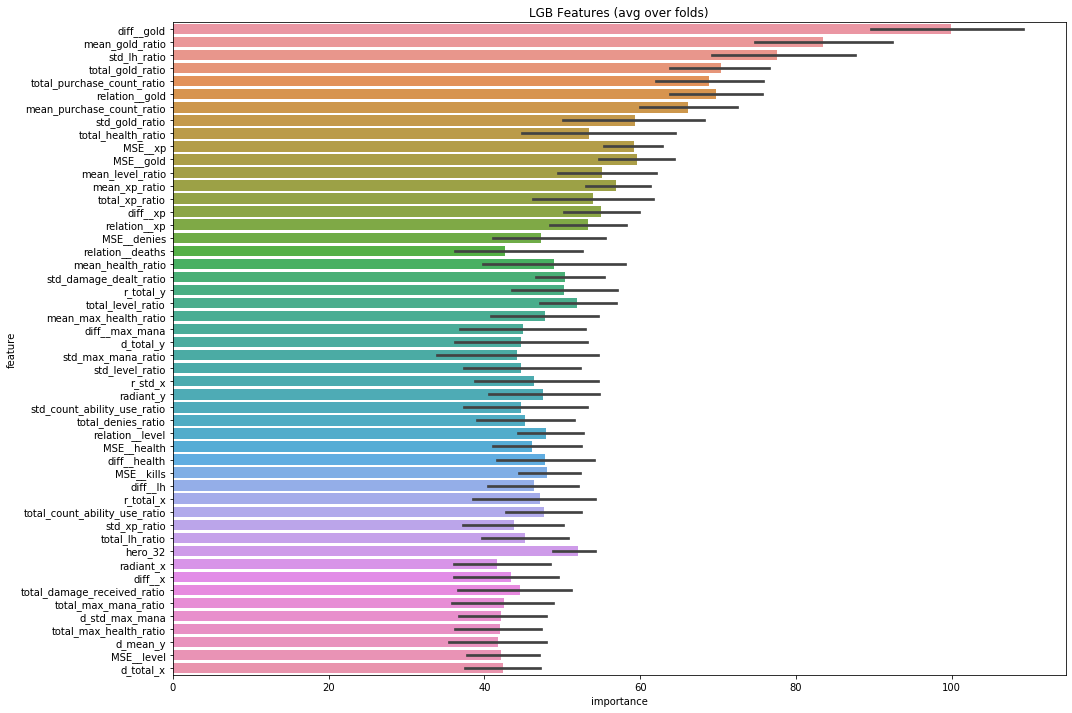

In [0]:
df_train_features_extd = df_train_features.copy()
df_test_features_extd  = df_test_features.copy()

df_train_features_extd = prepare_data_v2(df_train_features_extd)
df_test_features_extd  = prepare_data_v2(df_test_features_extd)

df_train = pd.concat([df_train_features_extd.copy(), df_train_heroes_ohe], axis = 1)
df_test  = pd.concat([df_test_features_extd.copy(),  df_test_heroes_ohe], axis = 1)

X_test = df_test.copy().reset_index(drop=True)
X = df_train.copy().reset_index(drop=True)
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [0]:
#add items
df_train_items = pd.read_csv(PATH_TO_DATA + 'df_items_train.csv', index_col = 'Unnamed: 0')
df_test_items  = pd.read_csv(PATH_TO_DATA + 'df_items_test.csv', index_col = 'Unnamed: 0')

Fold 0 started at Mon Nov 18 11:12:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.899681	valid_1's auc: 0.84099
[2000]	training's auc: 0.944522	valid_1's auc: 0.845358
[3000]	training's auc: 0.971747	valid_1's auc: 0.846247
Early stopping, best iteration is:
[3785]	training's auc: 0.984942	valid_1's auc: 0.846539
Fold 1 started at Mon Nov 18 11:14:53 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.901107	valid_1's auc: 0.829259
[2000]	training's auc: 0.944772	valid_1's auc: 0.833744
[3000]	training's auc: 0.971545	valid_1's auc: 0.835087
Early stopping, best iteration is:
[3419]	training's auc: 0.97935	valid_1's auc: 0.835451
Fold 2 started at Mon Nov 18 11:17:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.899304	valid_1's auc: 0.843963
[2000]	training's auc: 0.943932	valid_1's auc: 0.847037
Early stopping, best iteration is:
[2184]	training's a

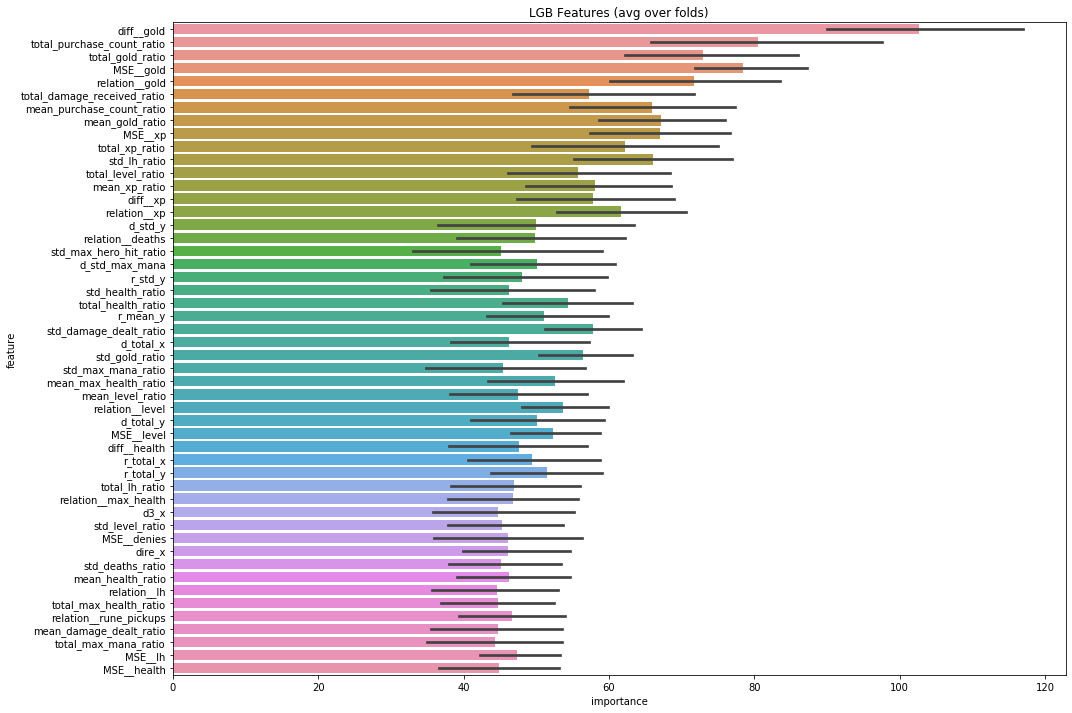

In [0]:
df_train = pd.concat([df_train_features_extd, df_train_heroes_ohe, df_train_items], axis = 1)
df_test  = pd.concat([df_test_features_extd,  df_test_heroes_ohe,  df_test_items],  axis = 1)

X_test = df_test.copy().reset_index(drop=True)
X = df_train.copy().reset_index(drop=True)
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [0]:
df_train_features_extd['r_kd'] = 0
ind = df_train_features_extd[df_train_features_extd['r_total_deaths'] > 0].index
df_train_features_extd.loc[ind,'r_kd'] = df_train_features_extd.loc[ind,'r_total_kills'] / df_train_features_extd.loc[ind,'r_total_deaths']

In [0]:
df_train_features_extd['d_kd'] = 0
ind = df_train_features_extd[df_train_features_extd['d_total_deaths'] > 0].index
df_train_features_extd.loc[ind,'d_kd'] = df_train_features_extd.loc[ind,'d_total_kills'] / df_train_features_extd.loc[ind,'d_total_deaths']

Fold 0 started at Mon Nov 18 11:32:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.899572	valid_1's auc: 0.841074
[2000]	training's auc: 0.944582	valid_1's auc: 0.845135
[3000]	training's auc: 0.971892	valid_1's auc: 0.84614
Early stopping, best iteration is:
[3390]	training's auc: 0.979206	valid_1's auc: 0.846405
Fold 1 started at Mon Nov 18 11:35:01 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.901164	valid_1's auc: 0.828411
[2000]	training's auc: 0.945269	valid_1's auc: 0.833313
[3000]	training's auc: 0.972091	valid_1's auc: 0.834606
Early stopping, best iteration is:
[3725]	training's auc: 0.984148	valid_1's auc: 0.83518
Fold 2 started at Mon Nov 18 11:37:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.899297	valid_1's auc: 0.843668
[2000]	training's auc: 0.944097	valid_1's auc: 0.846551
Early stopping, best iteration is:
[2712]	training's a

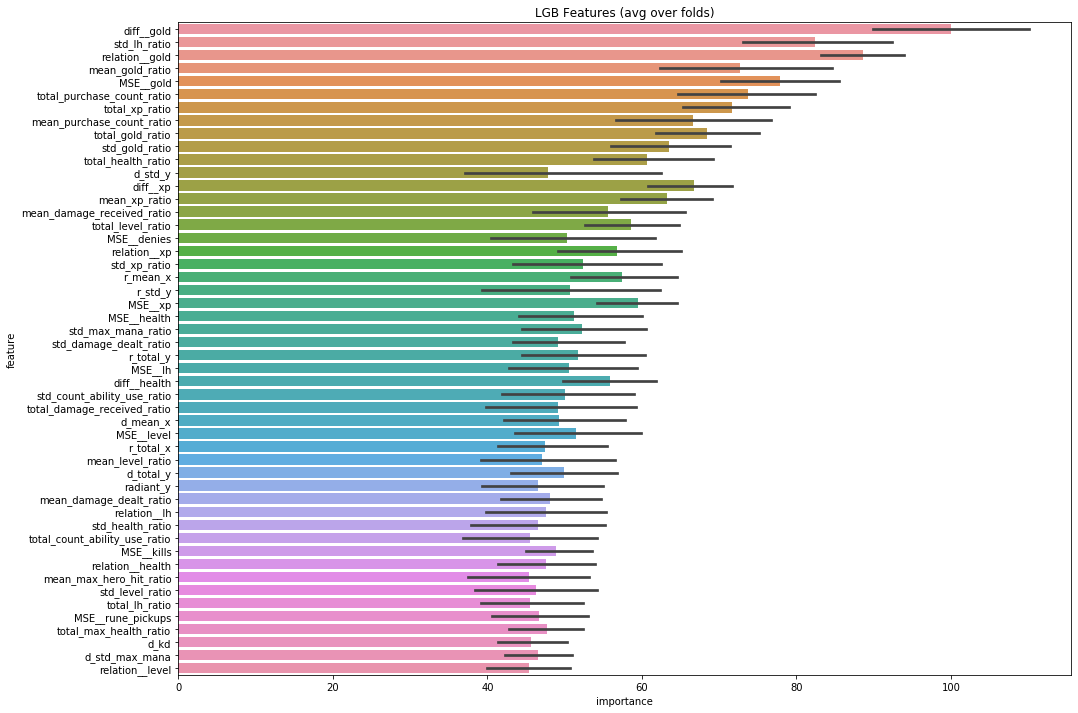

In [0]:
df_train = pd.concat([df_train_features_extd, df_train_heroes_ohe, df_train_items], axis = 1)
df_test  = pd.concat([df_test_features_extd,  df_test_heroes_ohe,  df_test_items],  axis = 1)

X_test = df_test.copy().reset_index(drop=True)
X = df_train.copy().reset_index(drop=True)
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [0]:
df_train_features_extd['r_xy'] = df_train_features_extd['r_total_x'] + df_train_features_extd['r_total_y']
df_train_features_extd['d_xy'] = df_train_features_extd['d_total_x'] + df_train_features_extd['d_total_y']

Fold 0 started at Mon Nov 18 12:02:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.899324	valid_1's auc: 0.840685
[2000]	training's auc: 0.944368	valid_1's auc: 0.845018
Early stopping, best iteration is:
[2735]	training's auc: 0.965854	valid_1's auc: 0.845738
Fold 1 started at Mon Nov 18 12:04:42 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.901072	valid_1's auc: 0.828457
[2000]	training's auc: 0.945202	valid_1's auc: 0.833517
Early stopping, best iteration is:
[2619]	training's auc: 0.963165	valid_1's auc: 0.834385
Fold 2 started at Mon Nov 18 12:06:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.899138	valid_1's auc: 0.843472
[2000]	training's auc: 0.944004	valid_1's auc: 0.847038
[3000]	training's auc: 0.971551	valid_1's auc: 0.84757
Early stopping, best iteration is:
[2917]	training's auc: 0.969758	valid_1's auc: 0.847599
Fold 3 started at 

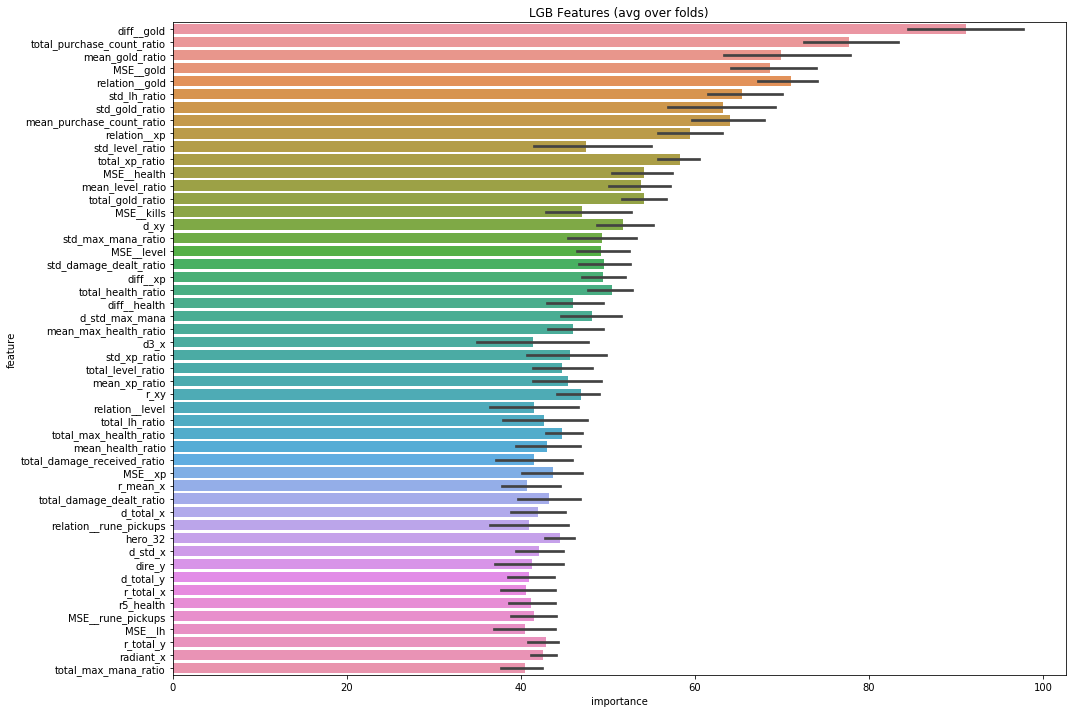

In [0]:
df_train = pd.concat([df_train_features_extd, df_train_heroes_ohe, df_train_items], axis = 1)
df_test  = pd.concat([df_test_features_extd,  df_test_heroes_ohe,  df_test_items],  axis = 1)

X_test = df_test.copy().reset_index(drop=True)
X = df_train.copy().reset_index(drop=True)
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Mon Nov 18 12:12:36 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.845154	valid_1's auc: 0.834376
[2000]	training's auc: 0.861522	valid_1's auc: 0.841569
[3000]	training's auc: 0.87361	valid_1's auc: 0.844176
[4000]	training's auc: 0.883669	valid_1's auc: 0.845577
[5000]	training's auc: 0.892796	valid_1's auc: 0.846477
[6000]	training's auc: 0.901017	valid_1's auc: 0.846878
[7000]	training's auc: 0.908763	valid_1's auc: 0.847218
Early stopping, best iteration is:
[7339]	training's auc: 0.911235	valid_1's auc: 0.847338
Fold 1 started at Mon Nov 18 12:15:10 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.847782	valid_1's auc: 0.821338
[2000]	training's auc: 0.863969	valid_1's auc: 0.828814
[3000]	training's auc: 0.875212	valid_1's auc: 0.831952
[4000]	training's auc: 0.884657	valid_1's auc: 0.83388
[5000]	training's auc: 0.893376	valid_1's auc: 0.835002
[6000]	training's auc: 0.90

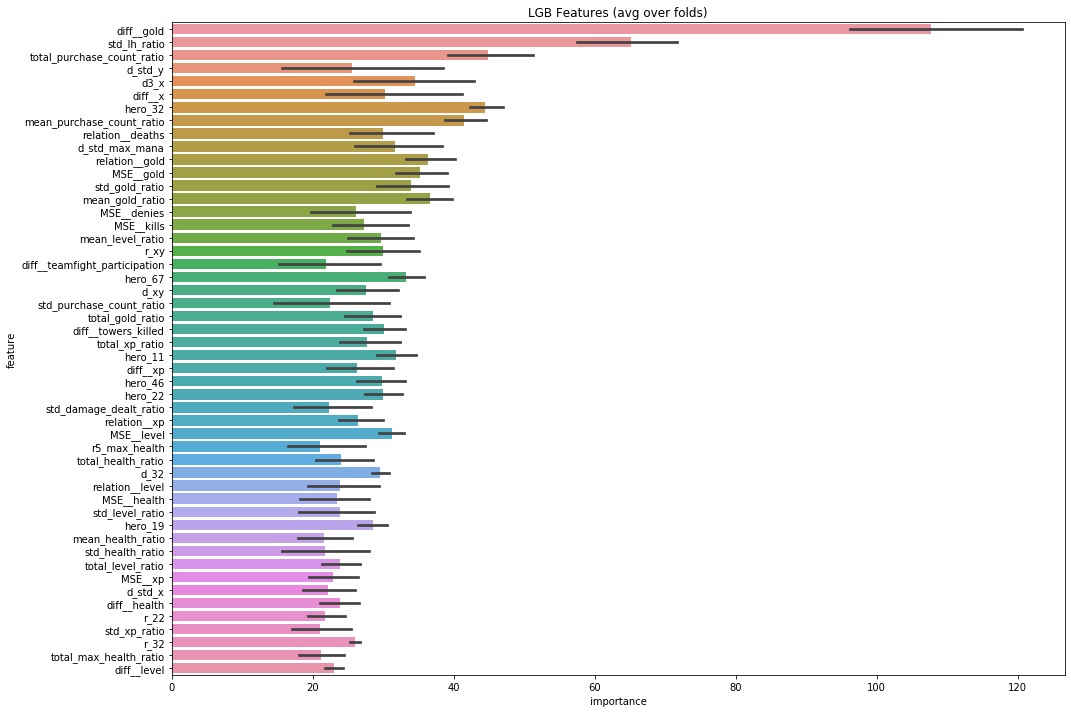

In [0]:
params2 ={'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': 3,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 16,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

X_test = df_test.copy().reset_index(drop=True)
X = df_train.copy().reset_index(drop=True)
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params2, folds=folds, model_type='lgb', plot_feature_importance=True)

In [0]:
df_submission = pd.DataFrame({'radiant_win_prob': prediction_lgb}, index=df_test_features.index)

In [0]:
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(PATH_TO_DATA + submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2019-11-18_12-24-21.csv
